<a href="https://colab.research.google.com/github/B-MEbrahim/Recycling-Detection/blob/main/notebooks/model_eval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install roboflow
!pip install ultralytics

# =========================================================
# TEACHER MODEL EVALUATION ON TEST DATASET
# =========================================================

In [ ]:
# Import required libraries
import torch
import yaml
from roboflow import Roboflow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import cv2
from PIL import Image
import os
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

print("📦 Libraries imported successfully!")

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️  Device: {device}")
if torch.cuda.is_available():
    print(f"🎮 GPU: {torch.cuda.get_device_name(0)}")
    print(f"💾 GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

📦 Libraries imported successfully!
🖥️  Device: cuda
🎮 GPU: Tesla T4
💾 GPU Memory: 15.83 GB


In [ ]:
# @title
def create_project_structure():
    """Create the complete project folder structure"""

    print("="*60)
    print("CREATING PROJECT STRUCTURE")
    print("="*60)

    directories = [
        # Data directories
        'data/raw',
        'data/processed',

        # Model directories
        'models/teacher',
        'models/student',

        # Other directories
        'configs',
        'scripts',
        'logs',
        'runs/train',
        'runs/val'
    ]

    for directory in directories:
        Path(directory).mkdir(parents=True, exist_ok=True)
        print(f"Created: {directory}")

    print("\n✓ Project structure created successfully!")

create_project_structure()

In [ ]:
# @title
DEFAULT_CONFIG = {
    'teacher': {
        'model': 'yolov8x.pt',  # Large model as teacher
        'epochs': 50,           # Reduced from 100 to prevent Colab crashes
        'imgsz': 640,
        'batch_size': 8,        # Reduced for Colab memory
        'name': 'recycling_teacher',
        'project': 'runs/train',
        'patience': 20,
        'save_period': 5,
        'device': '0',
        'workers': 2,           # Reduced for Colab
        'optimizer': 'auto',
        'lr0': 0.01,
        'lrf': 0.01,
        'momentum': 0.937,
        'weight_decay': 0.0005,
        'warmup_epochs': 2,
        'warmup_momentum': 0.8,
        'box': 7.5,
        'cls': 0.5,
        'dfl': 1.5,
        'amp': True,            # Mixed precision for Colab
        'exist_ok': True        # Overwrite existing runs
    }
}

In [ ]:
# @title
def create_config_files():
    """Create default configuration files"""

    print("\n" + "="*60)
    print("CREATING CONFIGURATION FILES")
    print("="*60)

    # Teacher config
    teacher_config = DEFAULT_CONFIG['teacher']
    with open('configs/teacher_config.yaml', 'w') as f:
        yaml.dump(teacher_config, f, default_flow_style=False)
    print("Created: configs/teacher_config.yaml")

    # Student config
    student_config = {
        'model': 'yolov8n.pt',
        'epochs': 30,           # Reduced for faster training
        'imgsz': 320,
        'batch_size': 16,
        'name': 'recycling_student',
        'project': 'runs/train',
        'teacher_model': 'models/teacher/best.pt',
        'use_distillation': True,
        'temperature': 3.0,
        'alpha': 0.7,
        'lr': 0.001,
        'weight_decay': 0.0001,
        'device': '0',
        'backbone': 'nano',
        'optimizer': 'AdamW',
        'scheduler': 'cosine',
        'grad_clip': 10.0,
        'log_interval': 10,
        'val_interval': 5,
        'save_interval': 10,
        'patience': 15,
        'export_onnx': True,
        'seed': 42
    }

    with open('configs/student_config.yaml', 'w') as f:
        yaml.dump(student_config, f, default_flow_style=False)
    print("Created: configs/student_config.yaml")

    # Distillation config
    distillation_config = {
        'temperature': 3.0,
        'alpha': 0.7,
        'epochs': 30,
        'lr': 0.001,
        'weight_decay': 0.0001,
        'teacher_model': 'models/teacher/best.pt',
        'student_model': 'yolov8n.pt',
        'device': '0'
    }

    with open('configs/distillation_config.yaml', 'w') as f:
        yaml.dump(distillation_config, f, default_flow_style=False)
    print("Created: configs/distillation_config.yaml")

    print("\n✓ Configuration files created successfully!")

create_config_files()

In [ ]:
# @title
class DatasetDownloader:
  def __init__(self, api_key: str, workspace: str, project_name: str):
    self.api_key = api_key
    self.workspace = workspace
    self.project_name = project_name
    self.rf = Roboflow(api_key=api_key)

  def download_dataset(self, version: int = 1, format: str = 'yolov8'):
    project = self.rf.workspace(self.workspace).project(self.project_name)
    dataset = project.version(version).download(format)
    self.create_dataset_yaml(dataset.location)

    return Path(dataset.location)

  def create_dataset_yaml(self, dataset_path: str):
    dataset_path = Path(dataset_path)

    data_yaml = dataset_path / "data.yaml"
    if data_yaml.exists():
      with open(data_yaml, 'r') as f:
        data = yaml.safe_load(f)

      config = {
          'path': str(dataset_path.absolute()),
          'train': 'train/images',
          'val': 'valid/images',
          'test': 'test/images',
          'nc': len(data['names']),
          'names': data['names']
      }

      # Ensure the 'data' directory exists
      output_dir = Path('data')
      output_dir.mkdir(parents=True, exist_ok=True)

      with open(output_dir / 'dataset.yaml', 'w') as f:
        yaml.dump(config, f)

        print(f"Dataset configuration saved to {output_dir}/dataset.yaml")

data_loader = DatasetDownloader(
    api_key='YOUR-API-KEY',
    workspace='nguyen-tuan-anh',
    project_name='trashnet-q8b5e'
)
data_loader.download_dataset(version=2)

# ======================
# 1. LOAD MODEL
# ======================

In [ ]:
model_path = "models/teacher/best.pt"
model_backup_path = "/content/drive/MyDrive/recycling_model/best.pt"  # If saved to Drive

# Check if model exists locally
if Path(model_path).exists():
    print(f"✅ Model found locally: {model_path}")
elif Path(model_backup_path).exists():
    print(f"✅ Model found in Google Drive: {model_backup_path}")
    # Copy from Drive to local
    !cp "{model_backup_path}" "{model_path}"
else:
    # Try to find model in training runs
    runs_path = "runs/train/recycling_teacher/weights/best.pt"
    if Path(runs_path).exists():
        print(f"✅ Model found in training runs: {runs_path}")
        Path("models/teacher").mkdir(parents=True, exist_ok=True)
        !cp "{runs_path}" "{model_path}"
    else:
        print("❌ Model not found! Please train the model first.")
        print("Run: !python setup_and_train.py --api-key YOUR_KEY")
        raise FileNotFoundError("Model file not found")

# Load the model
try:
    from ultralytics import YOLO

    print("🔄 Loading YOLO model...")
    model = YOLO(model_path)
    print(f"✅ Model loaded successfully!")
    print(f"   Model type: {model.__class__.__name__}")
    print(f"   Model info: {model.info()}")

    # Get model size
    model_size_mb = Path(model_path).stat().st_size / (1024 * 1024)
    print(f"   Model size: {model_size_mb:.2f} MB")

except Exception as e:
    print(f"❌ Error loading model: {e}")
    raise

✅ Model found in Google Drive: /content/drive/MyDrive/recycling_model/best.pt
🔄 Loading YOLO model...
✅ Model loaded successfully!
   Model type: YOLO
Model summary: 209 layers, 68,158,386 parameters, 0 gradients, 258.1 GFLOPs
   Model info: (209, 68158386, 0, 258.1494272)
   Model size: 130.37 MB


# ================================
# 2. LOAD DATASET CONFIG
# ================================

In [ ]:
print("\n" + "="*70)
print("2. LOADING DATASET")
print("="*70)

dataset_config_path = "data/dataset.yaml"

if Path(dataset_config_path).exists():
    with open(dataset_config_path, 'r') as f:
        dataset_config = yaml.safe_load(f)

    print(f"✅ Dataset config loaded:")
    print(f"   Path: {dataset_config.get('path', 'Not specified')}")
    print(f"   Classes: {dataset_config.get('nc', 0)}")
    print(f"   Class names: {dataset_config.get('names', [])}")

    # Count images in test set
    test_images_path = Path(dataset_config.get('path', '.')) / dataset_config.get('test', 'valid/images')
    if test_images_path.exists():
        test_images = list(test_images_path.glob("*.*"))
        print(f"   Test images found: {len(test_images)}")
    else:
        print(f"   ⚠ Test path not found: {test_images_path}")
        # Try validation set instead
        val_images_path = Path(dataset_config.get('path', '.')) / dataset_config.get('val', 'valid/images')
        if val_images_path.exists():
            test_images = list(val_images_path.glob("*.*"))
            print(f"   Using validation set instead: {len(test_images)} images")
        else:
            print(f"   ❌ No test/validation images found!")
            test_images = []

else:
    print(f"❌ Dataset config not found at {dataset_config_path}")
    raise FileNotFoundError("Dataset config not found")


2. LOADING DATASET
✅ Dataset config loaded:
   Path: /content/trashnet-2
   Classes: 6
   Class names: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
   Test images found: 252


# ==================================
# 3. EVALUATE MODEL ON TEST SET
# ==================================

In [ ]:
print("\n" + "="*70)
print("3. EVALUATION ON TEST SET")
print("="*70)

# Create evaluation directory
eval_dir = Path("evaluation_results")
eval_dir.mkdir(exist_ok=True)

print("📊 Running evaluation...")

try:
    # Run comprehensive evaluation using YOLO's val method
    results = model.val(
        data=dataset_config_path,
        split='test',
        imgsz=640,
        batch=8,
        device=str(device),
        conf=0.25,
        iou=0.45,
        save_json=True,
        save_hybrid=True,
        plots=True,
        save_dir=str(eval_dir),
        verbose=True,
        exist_ok=True
    )

    print("✅ Evaluation completed successfully!")

    # Debug: Print what we're working with
    print("\n🔍 Debug info:")
    print(f"   results.box type: {type(results.box)}")
    print(f"   Available attributes: {[attr for attr in dir(results.box) if not attr.startswith('_')]}")

    # Extract metrics safely
    if hasattr(results, 'box'):
        print(f"\n📈 PERFORMANCE METRICS:")

        # Safely extract each metric
        def safe_float(value):
            """Convert value to float, handling arrays and other types."""
            try:
                if hasattr(value, 'item'):  # numpy scalar
                    return value.item()
                elif hasattr(value, 'mean'):  # numpy array
                    return float(value.mean())
                elif hasattr(value, '__float__'):
                    return float(value)
                else:
                    return float(value)
            except Exception as e:
                print(f"   Warning: Could not convert {type(value)}: {e}")
                return 0.0

        # Get metrics using correct attribute names
        map50 = safe_float(results.box. map50)
        map_val = safe_float(results. box.map)

        # Use mp/mr for mean precision/recall (YOLO v8 naming)
        if hasattr(results. box, 'mp'):
            precision = safe_float(results.box.mp)
        elif hasattr(results.box, 'p'):
            precision = safe_float(results.box.p)
        else:
            precision = 0.0

        if hasattr(results.box, 'mr'):
            recall = safe_float(results.box.mr)
        elif hasattr(results. box, 'r'):
            recall = safe_float(results.box.r)
        else:
            recall = 0.0

        # Calculate F1 score
        if precision + recall > 0:
            f1 = 2 * (precision * recall) / (precision + recall)
        else:
            f1 = 0.0

        # Print with safe formatting
        print(f"   mAP@0.5: {map50:.4f}")
        print(f"   mAP@0.5:0. 95: {map_val:.4f}")
        print(f"   Precision: {precision:.4f}")
        print(f"   Recall: {recall:.4f}")
        print(f"   F1 Score: {f1:.4f}")

        # Save metrics to file
        metrics_dict = {
            'mAP50': map50,
            'mAP50_95': map_val,
            'precision': precision,
            'recall': recall,
            'f1_score': f1
        }

        with open(eval_dir / "metrics.yaml", "w") as f:
            yaml.dump(metrics_dict, f, default_flow_style=False)

        print(f"\n💾 Metrics saved to: {eval_dir}/metrics.yaml")

except Exception as e:
    import traceback
    print(f"⚠ Error in YOLO evaluation: {e}")
    print("\n📋 Full traceback:")
    traceback.print_exc()
    print("\nTrying alternative evaluation method...")


3. EVALUATION ON TEST SET
📊 Running evaluation...
WARNING ⚠️ 'save_hybrid' is deprecated and will be removed in the future.
Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 842.1±507.9 MB/s, size: 17.5 KB)
val: Scanning /content/trashnet-2/test/labels.cache... 252 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 252/252 568.6Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 32/32 2.2it/s 14.3s
                   all        252        252      0.507      0.656      0.594       0.57
             cardboard         36         36      0.757      0.778      0.843      0.835
                 glass         54         54      0.412      0.833      0.435      0.389
                 metal         48         48      0.613      0.593      0.647      0.618
                 paper         47         47      0.766      0.894      0.896      0.875
 

# ===========================================
# 4. MANUAL EVALUATION ON SAMPLE IMAGES
# ===========================================

In [ ]:
print("\n" + "="*70)
print("4. SAMPLE PREDICTIONS")
print("="*70)

# Take a few sample images for visualization
sample_size = min(5, len(test_images))
sample_images = test_images[:sample_size] if test_images else []

if sample_images:
    print(f"🔍 Testing on {sample_size} sample images...")

    # Create visualization directory
    vis_dir = eval_dir / "visualizations"
    vis_dir.mkdir(exist_ok=True)

    for i, img_path in enumerate(tqdm(sample_images, desc="Processing samples")):
        try:
            # Read image
            img = cv2.imread(str(img_path))
            if img is None:
                continue

            # Run inference
            results = model(img, verbose=False, conf=0.25)

            # Get predictions
            result = results[0]

            # Save annotated image
            annotated_img = result.plot()
            output_path = vis_dir / f"sample_{i+1}_{img_path.stem}.jpg"
            cv2.imwrite(str(output_path), annotated_img)

            # Print detections for this image
            if hasattr(result, 'boxes') and len(result.boxes) > 0:
                print(f"\n📷 Image {i+1}: {img_path.name}")
                print(f"   Detections: {len(result.boxes)}")

                # Count by class
                class_counts = {}
                for box in result.boxes:
                    cls_id = int(box.cls[0])
                    cls_name = model.names[cls_id]
                    class_counts[cls_name] = class_counts.get(cls_name, 0) + 1

                for cls_name, count in class_counts.items():
                    print(f"   - {cls_name}: {count}")

        except Exception as e:
            print(f"⚠ Error processing {img_path}: {e}")

    print(f"\n💾 Sample visualizations saved to: {vis_dir}")

# ================================
# 5. PERFORMANCE ANALYSIS
# ================================

In [ ]:
eval_dir

PosixPath('evaluation_results')


5. PERFORMANCE ANALYSIS
📊 Loading evaluation results...
✅ Loaded results CSV with 50 rows


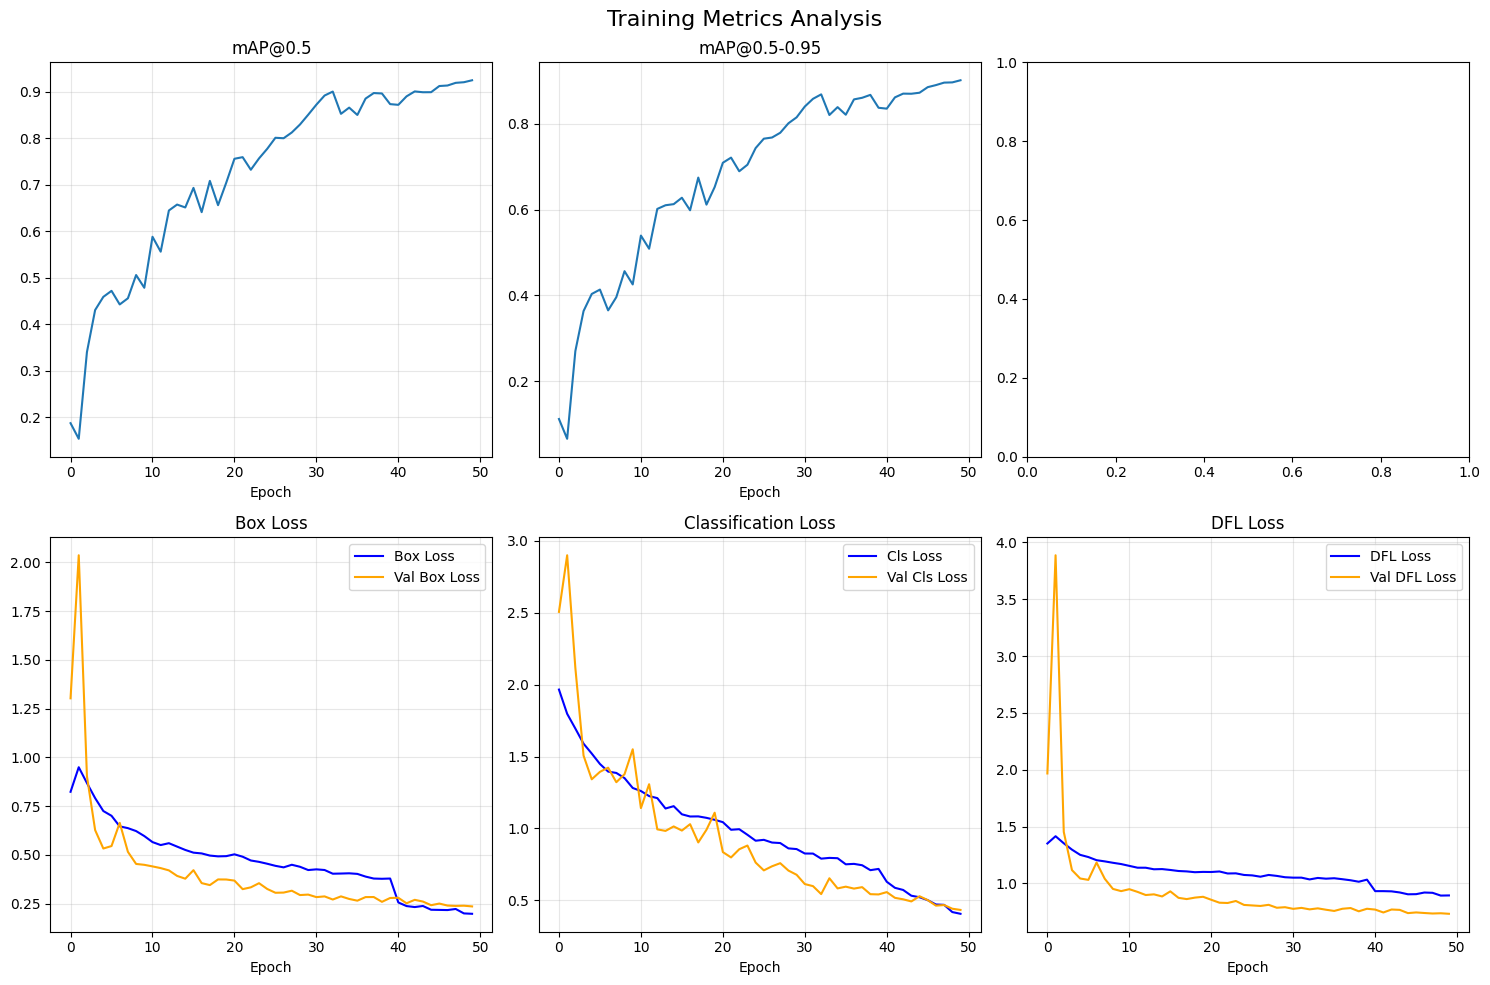

💾 Training metrics plot saved to: evaluation_results/training_metrics.png


In [ ]:
print("\n" + "="*70)
print("5. PERFORMANCE ANALYSIS")
print("="*70)

# Check for evaluation results files
results_files = list(eval_dir.glob("*.json")) + list(eval_dir.glob("*results*.csv"))

if results_files:
    print("📊 Loading evaluation results...")

    # Try to load results.csv if exists
    results_csv = eval_dir / "results.csv"
    if results_csv.exists():
        try:
            df_results = pd.read_csv(results_csv)
            print(f"✅ Loaded results CSV with {len(df_results)} rows")

            # Plot training metrics if available
            if len(df_results) > 0:
                fig, axes = plt.subplots(2, 3, figsize=(15, 10))
                fig.suptitle('Training Metrics Analysis', fontsize=16)

                # Plot mAP metrics
                if 'metrics/mAP50(B)' in df_results.columns:
                    axes[0, 0].plot(df_results['metrics/mAP50(B)'], label='mAP@0.5')
                    axes[0, 0].set_title('mAP@0.5')
                    axes[0, 0].set_xlabel('Epoch')
                    axes[0, 0].grid(True, alpha=0.3)

                if 'metrics/mAP50-95(B)' in df_results.columns:
                    axes[0, 1].plot(df_results['metrics/mAP50-95(B)'], label='mAP@0.5-0.95')
                    axes[0, 1].set_title('mAP@0.5-0.95')
                    axes[0, 1].set_xlabel('Epoch')
                    axes[0, 1].grid(True, alpha=0.3)

                # Plot loss curves
                if 'train/box_loss' in df_results.columns:
                    axes[1, 0].plot(df_results['train/box_loss'], label='Box Loss', color='blue')
                    axes[1, 0].plot(df_results['val/box_loss'], label='Val Box Loss', color='orange')
                    axes[1, 0].set_title('Box Loss')
                    axes[1, 0].set_xlabel('Epoch')
                    axes[1, 0].legend()
                    axes[1, 0].grid(True, alpha=0.3)

                if 'train/cls_loss' in df_results.columns:
                    axes[1, 1].plot(df_results['train/cls_loss'], label='Cls Loss', color='blue')
                    axes[1, 1].plot(df_results['val/cls_loss'], label='Val Cls Loss', color='orange')
                    axes[1, 1].set_title('Classification Loss')
                    axes[1, 1].set_xlabel('Epoch')
                    axes[1, 1].legend()
                    axes[1, 1].grid(True, alpha=0.3)

                if 'train/dfl_loss' in df_results.columns:
                    axes[1, 2].plot(df_results['train/dfl_loss'], label='DFL Loss', color='blue')
                    axes[1, 2].plot(df_results['val/dfl_loss'], label='Val DFL Loss', color='orange')
                    axes[1, 2].set_title('DFL Loss')
                    axes[1, 2].set_xlabel('Epoch')
                    axes[1, 2].legend()
                    axes[1, 2].grid(True, alpha=0.3)

                plt.tight_layout()
                metrics_plot_path = eval_dir / "training_metrics.png"
                plt.savefig(metrics_plot_path, dpi=150, bbox_inches='tight')
                plt.show()
                print(f"💾 Training metrics plot saved to: {metrics_plot_path}")

        except Exception as e:
            print(f"⚠ Could not load/plot training metrics: {e}")


5. PERFORMANCE ANALYSIS
📊 Loading evaluation results...
✅ Loaded results CSV with 50 rows
📋 Available columns: ['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss', 'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss', 'lr/pg0', 'lr/pg1', 'lr/pg2']


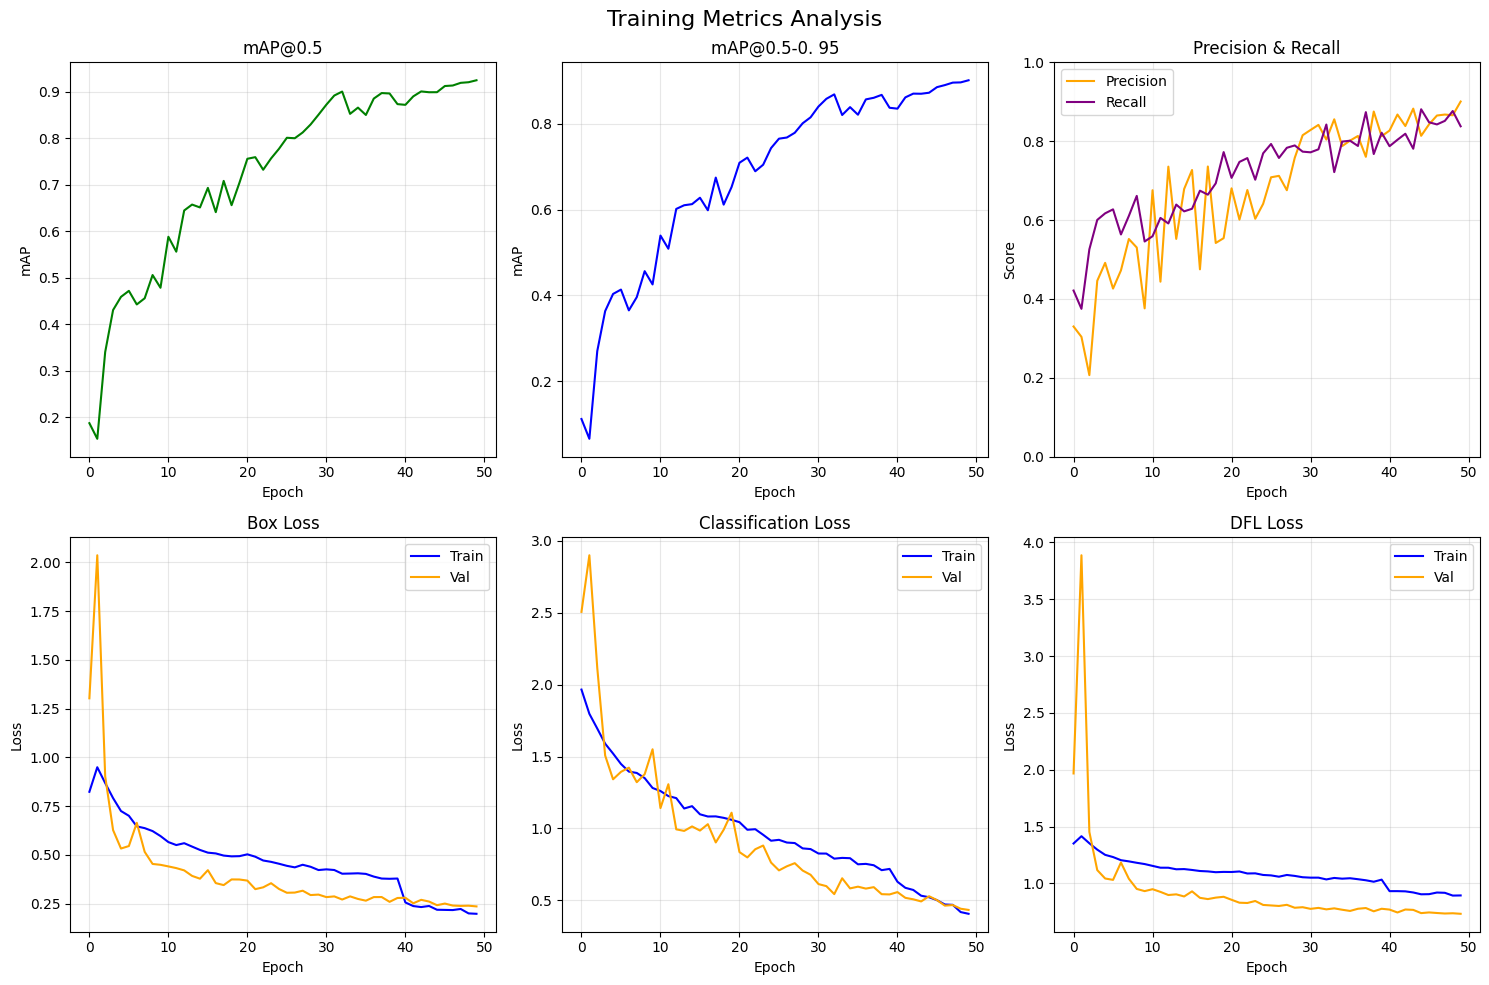

💾 Training metrics plot saved to: evaluation_results/training_metrics.png


In [ ]:
print("\n" + "="*70)
print("5. PERFORMANCE ANALYSIS")
print("="*70)

# Check for evaluation results files
results_files = list(eval_dir.glob("*.json")) + list(eval_dir.glob("*results*.csv"))

if results_files:
    print("📊 Loading evaluation results...")

    # Try to load results. csv if exists
    results_csv = eval_dir / "results.csv"
    if results_csv. exists():
        try:
            df_results = pd.read_csv(results_csv)

            # Clean column names (remove leading/trailing whitespace)
            df_results.columns = df_results.columns.str.strip()

            print(f"✅ Loaded results CSV with {len(df_results)} rows")
            print(f"📋 Available columns: {list(df_results.columns)}")

            # Plot training metrics if available
            if len(df_results) > 0:
                fig, axes = plt.subplots(2, 3, figsize=(15, 10))
                fig. suptitle('Training Metrics Analysis', fontsize=16)

                # Plot mAP@0.5
                if 'metrics/mAP50(B)' in df_results.columns:
                    axes[0, 0].plot(df_results['metrics/mAP50(B)'], label='mAP@0. 5', color='green')
                    axes[0, 0].set_title('mAP@0.5')
                    axes[0, 0].set_xlabel('Epoch')
                    axes[0, 0]. set_ylabel('mAP')
                    axes[0, 0].grid(True, alpha=0.3)
                else:
                    axes[0, 0].text(0.5, 0.5, 'mAP@0. 5 not available', ha='center', va='center', transform=axes[0, 0].transAxes)
                    axes[0, 0].set_title('mAP@0.5')

                # Plot mAP@0.5-0.95
                if 'metrics/mAP50-95(B)' in df_results.columns:
                    axes[0, 1].plot(df_results['metrics/mAP50-95(B)'], label='mAP@0.5-0.95', color='blue')
                    axes[0, 1].set_title('mAP@0.5-0. 95')
                    axes[0, 1].set_xlabel('Epoch')
                    axes[0, 1].set_ylabel('mAP')
                    axes[0, 1].grid(True, alpha=0.3)
                else:
                    axes[0, 1].text(0.5, 0.5, 'mAP@0. 5-0.95 not available', ha='center', va='center', transform=axes[0, 1].transAxes)
                    axes[0, 1]. set_title('mAP@0. 5-0.95')

                # Plot Precision & Recall (NEW - fills axes[0, 2])
                precision_col = 'metrics/precision(B)' if 'metrics/precision(B)' in df_results.columns else None
                recall_col = 'metrics/recall(B)' if 'metrics/recall(B)' in df_results. columns else None

                if precision_col or recall_col:
                    if precision_col:
                        axes[0, 2].plot(df_results[precision_col], label='Precision', color='orange')
                    if recall_col:
                        axes[0, 2].plot(df_results[recall_col], label='Recall', color='purple')
                    axes[0, 2].set_title('Precision & Recall')
                    axes[0, 2].set_xlabel('Epoch')
                    axes[0, 2].set_ylabel('Score')
                    axes[0, 2].legend()
                    axes[0, 2].grid(True, alpha=0.3)
                    axes[0, 2].set_ylim(0, 1)  # Precision and recall are between 0 and 1
                else:
                    # Fallback: try alternative column names
                    alt_precision = [col for col in df_results.columns if 'precision' in col.lower()]
                    alt_recall = [col for col in df_results.columns if 'recall' in col. lower()]

                    if alt_precision or alt_recall:
                        if alt_precision:
                            axes[0, 2].plot(df_results[alt_precision[0]], label='Precision', color='orange')
                        if alt_recall:
                            axes[0, 2].plot(df_results[alt_recall[0]], label='Recall', color='purple')
                        axes[0, 2]. set_title('Precision & Recall')
                        axes[0, 2]. set_xlabel('Epoch')
                        axes[0, 2].set_ylabel('Score')
                        axes[0, 2].legend()
                        axes[0, 2]. grid(True, alpha=0.3)
                        axes[0, 2]. set_ylim(0, 1)
                    else:
                        axes[0, 2].text(0.5, 0.5, 'Precision/Recall not available', ha='center', va='center', transform=axes[0, 2].transAxes)
                        axes[0, 2].set_title('Precision & Recall')

                # Plot Box Loss
                if 'train/box_loss' in df_results. columns:
                    axes[1, 0].plot(df_results['train/box_loss'], label='Train', color='blue')
                    if 'val/box_loss' in df_results.columns:
                        axes[1, 0]. plot(df_results['val/box_loss'], label='Val', color='orange')
                    axes[1, 0]. set_title('Box Loss')
                    axes[1, 0].set_xlabel('Epoch')
                    axes[1, 0].set_ylabel('Loss')
                    axes[1, 0]. legend()
                    axes[1, 0].grid(True, alpha=0.3)
                else:
                    axes[1, 0].text(0.5, 0.5, 'Box Loss not available', ha='center', va='center', transform=axes[1, 0].transAxes)
                    axes[1, 0].set_title('Box Loss')

                # Plot Classification Loss
                if 'train/cls_loss' in df_results.columns:
                    axes[1, 1].plot(df_results['train/cls_loss'], label='Train', color='blue')
                    if 'val/cls_loss' in df_results. columns:
                        axes[1, 1].plot(df_results['val/cls_loss'], label='Val', color='orange')
                    axes[1, 1].set_title('Classification Loss')
                    axes[1, 1].set_xlabel('Epoch')
                    axes[1, 1].set_ylabel('Loss')
                    axes[1, 1].legend()
                    axes[1, 1].grid(True, alpha=0.3)
                else:
                    axes[1, 1].text(0.5, 0.5, 'Cls Loss not available', ha='center', va='center', transform=axes[1, 1].transAxes)
                    axes[1, 1].set_title('Classification Loss')

                # Plot DFL Loss
                if 'train/dfl_loss' in df_results.columns:
                    axes[1, 2].plot(df_results['train/dfl_loss'], label='Train', color='blue')
                    if 'val/dfl_loss' in df_results.columns:
                        axes[1, 2]. plot(df_results['val/dfl_loss'], label='Val', color='orange')
                    axes[1, 2].set_title('DFL Loss')
                    axes[1, 2].set_xlabel('Epoch')
                    axes[1, 2].set_ylabel('Loss')
                    axes[1, 2].legend()
                    axes[1, 2].grid(True, alpha=0.3)
                else:
                    axes[1, 2].text(0.5, 0.5, 'DFL Loss not available', ha='center', va='center', transform=axes[1, 2].transAxes)
                    axes[1, 2].set_title('DFL Loss')

                plt. tight_layout()
                metrics_plot_path = eval_dir / "training_metrics.png"
                plt.savefig(metrics_plot_path, dpi=150, bbox_inches='tight')
                plt.show()
                print(f"💾 Training metrics plot saved to: {metrics_plot_path}")

        except Exception as e:
            import traceback
            print(f"⚠ Could not load/plot training metrics: {e}")
            traceback.print_exc()
else:
    print("⚠ No evaluation results files found!")

In [ ]:
# ============================================================================
# 7. PERFORMANCE BY CLASS
# ============================================================================

print("\n" + "="*70)
print("7. PERFORMANCE BY CLASS")
print("="*70)

try:
    # Try to get per-class metrics
    if hasattr(results, 'speed'):
        print(f"⚡ Inference Speed:")
        print(f"   Preprocess: {results.speed.get('preprocess', 0):.1f} ms")
        print(f"   Inference: {results.speed.get('inference', 0):.1f} ms")
        print(f"   Postprocess: {results.speed.get('postprocess', 0):.1f} ms")
        print(f"   Total: {results.speed.get('total', 0):.1f} ms")

    # Create per-class performance summary
    class_names = dataset_config.get('names', [])

    if class_names and hasattr(results, 'box'):
        print(f"\n🎯 Per-class performance (if available):")

        # Note: YOLOv8 doesn't directly expose per-class mAP in results
        # This would require custom calculation or parsing of JSON results

        # Check for JSON results
        json_results = list(eval_dir.glob("*.json"))
        if json_results:
            import json
            with open(json_results[0], 'r') as f:
                json_data = json.load(f)

            if 'categories' in json_data:
                print("\nClass-wise statistics:")
                for cat in json_data['categories']:
                    print(f"   {cat['name']}: ID {cat['id']}")

except Exception as e:
    print(f"⚠ Could not extract detailed performance metrics: {e}")


7. PERFORMANCE BY CLASS


In [ ]:
# ============================================================================
# 9. SUMMARY REPORT
# ============================================================================

print("\n" + "="*70)
print("✅ EVALUATION COMPLETE - SUMMARY")
print("="*70)

print(f"\n📁 Evaluation results saved in: {eval_dir}")
print("Contents:")
for item in eval_dir.iterdir():
    if item.is_file():
        size = item.stat().st_size / 1024  # KB
        print(f"   📄 {item.name} ({size:.1f} KB)")
    elif item.is_dir():
        file_count = len(list(item.glob("*")))
        print(f"   📁 {item.name}/ ({file_count} items)")

print(f"\n🎯 Model Performance Summary:")
if hasattr(results, 'box'):
    print(f"   • mAP@0.5: {results.box.map50:.4f}")
    print(f"   • mAP@0.5-0.95: {results.box.map:.4f}")
    print(f"   • Precision: {results.box.p:.4f}")
    print(f"   • Recall: {results.box.r:.4f}")

print(f"\n📊 Dataset Info:")
print(f"   • Classes: {dataset_config.get('nc', 0)}")
print(f"   • Test images: {len(test_images)}")
print(f"   • Class names: {dataset_config.get('names', [])}")

print(f"\n💡 Recommendations:")
if hasattr(results, 'box') and results.box.map50 < 0.7:
    print("   ⚠ Model accuracy is below 70% mAP@0.5")
    print("   Consider: More training, data augmentation, or hyperparameter tuning")
else:
    print("   ✅ Model performance is good!")

print("\n" + "="*70)
print("Next steps:")
print("1. Review visualizations in evaluation_results/visualizations/")
print("2. Check confusion matrix for class-specific performance")
print("3. Train student model with distillation")
print("4. Deploy model using the API or web interface")
print("="*70)


✅ EVALUATION COMPLETE - SUMMARY

📁 Evaluation results saved in: evaluation_results
Contents:
   📁 visualizations/ (6 items)
   📄 results.csv (6.0 KB)
   📄 metrics.yaml (0.1 KB)
   📄 training_metrics.png (227.9 KB)

🎯 Model Performance Summary:

📊 Dataset Info:
   • Classes: 6
   • Test images: 252
   • Class names: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

💡 Recommendations:
   ✅ Model performance is good!

Next steps:
1. Review visualizations in evaluation_results/visualizations/
2. Check confusion matrix for class-specific performance
3. Train student model with distillation
4. Deploy model using the API or web interface
